In [1]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf


import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout, MaxPooling2D, UpSampling2D,LeakyReLU,ZeroPadding2D,multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

from tensorflow.keras.layers import LeakyReLU

from keras.layers import Activation, SpatialDropout2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers import Dense, Lambda
from keras.layers import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

2024-06-25 20:40:42.707994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 20:40:42.746395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 20:40:42.746425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 20:40:42.748208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 20:40:42.754715: I tensorflow/core/platform/cpu_feature_guar

Tensorflow ver. 2.15.0
Num GPUs Available: 0


2024-06-25 20:40:44.423320: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-25 20:40:44.423341: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: sukrit
2024-06-25 20:40:44.423344: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: sukrit
2024-06-25 20:40:44.423415: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-06-25 20:40:44.423424: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-06-25 20:40:44.423425: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.154.5


In [2]:
# Input image size that we are going to use
IMAGE_SIZE = 512
num_classes = 4
# Set batch size
batch = 8
# Set learning rate
LR = 1e-4
# Set epoch
EPOCHS = 140

In [3]:
# Set image and mask paths
image_path = "../images/"
mask_path = "../masks/"
training_data = "train/"
# val_data = "validation/"
test_data = "test/"

In [4]:
# Function to create lists of paths for training, validation and testing data
def load_data():
  extensions = ["*.jpg", "*.tif", "*.tiff"]
  file_patterns = [os.path.join(image_path, training_data, ext) for ext in extensions]

  TRAIN_X = sorted(sum((glob(pattern) for pattern in file_patterns), []))
  train_x = TRAIN_X
# image_path
  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.png")))
  train_y = TRAIN_Y

  file_patterns = [os.path.join(image_path, test_data, ext) for ext in extensions]
  TEST_X = sorted(sum((glob(pattern) for pattern in file_patterns), []))
  test_x = TEST_X
  TEST_Y = sorted(glob(os.path.join(mask_path + test_data, "*.png")))
  test_y = TEST_Y

  # return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
  return (train_x, train_y), (test_x, test_y)



In [5]:
(train_x, train_y),(test_x, test_y) = load_data()


print("Training data: ", len(train_x))
print("Test data: ", len(test_y))

Training data:  161
Test data:  40


In [7]:
# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

In [8]:
# Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4
    
def tf_dataset_train(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    # newdataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

def tf_dataset_test(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [9]:
train_dataset = tf_dataset_train(train_x, train_y)
test_dataset = tf_dataset_test(test_x, test_y)

In [10]:
# Function to load image/mask and convert colour space from BGR to RGB so that image/mask can be displayed correctly by matplotlib
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [11]:
tf.random.set_seed(42) 
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding,kernel_initializer = 'random_normal')(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [12]:
def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(4, (1,1), padding="same", activation="softmax")(uconv0)    
    
    model = Model(input, output_layer)
    # model.name = 'u-xception'

    return model


In [13]:
model = UXception(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
#https://www.kaggle.com/code/meaninglesslives/unet-xception-keras-for-pneumothorax-segmentation#Useful-Model-Blocks

In [16]:
# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-140]

In [17]:
# Freeze the encoder layers for transfer learning (so that weights are only Augmentedchanged for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    # print(layer, layer.trainable)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 255, 255, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 255, 255, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 255, 255, 32)         0         ['block1_conv1_bn[0][0]'] 

In [19]:
# Functions for dice coefficient and dice loss 

import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    true_sum = K.sum(y_true_f , axis=-1)
    pred_sum = K.sum(y_pred_f, axis=-1)
    return K.mean((2. * intersect / (true_sum+pred_sum + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred, num_classes=4):
  smooth = 1e-7  
  y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[..., 1:])
  y_pred_f = K.flatten(y_pred[..., 1:])
  intersection = K.sum(K.cast(y_true_f * y_pred_f, dtype='float32'), axis=-1)
  set_sum = K.sum(K.cast(y_true_f + y_pred_f, dtype='float32'), axis=-1)
  iou = (intersection + smooth) / (set_sum -intersection+ smooth)
  mIoU = K.mean(iou)
  return mIoU

def mIoU_loss(y_true, y_pred):
    return 1 - mean_iou(y_true, y_pred)
   


In [20]:
# Set up loss function, optimiser and complile the model 
opt = tf.keras.optimizers.AdamW(LR)
metrics = [dice_coef,mean_iou]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [21]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='mean_iou', 
    patience=10, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='mean_iou', 
    factor=0.8,   
    patience=4, 
    min_lr=0.0001,
)


In [22]:
# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = 'checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='mean_iou',
    mode='max',
    save_best_only=True)

In [23]:
# Commencement of training
train_steps = len(train_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1

history=model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[model_checkpoint_callback,early_stopping]
)


Epoch 1/140


2024-06-25 20:41:25.091335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/batch_normalization_5/FusedBatchNormV3' exist for missing node 'model/conv2d_4/BiasAdd'.


21/21 [==============================] - 88s 3s/step - loss: 0.6225 - dice_coef: 0.3775 - mean_iou: 0.2332
Epoch 2/140
21/21 [==============================] - 134s 7s/step - loss: 0.5028 - dice_coef: 0.4972 - mean_iou: 0.3322
Epoch 3/140
21/21 [==============================] - 78s 4s/step - loss: 0.3743 - dice_coef: 0.6257 - mean_iou: 0.4571
Epoch 4/140
21/21 [==============================] - 77s 4s/step - loss: 0.3078 - dice_coef: 0.6922 - mean_iou: 0.5311
Epoch 5/140
21/21 [==============================] - 76s 4s/step - loss: 0.2552 - dice_coef: 0.7448 - mean_iou: 0.5949
Epoch 6/140
21/21 [==============================] - 77s 4s/step - loss: 0.2605 - dice_coef: 0.7395 - mean_iou: 0.5883
Epoch 7/140
21/21 [==============================] - 84s 4s/step - loss: 0.2319 - dice_coef: 0.7681 - mean_iou: 0.6248
Epoch 8/140
21/21 [==============================] - 75s 4s/step - loss: 0.2326 - dice_coef: 0.7674 - mean_iou: 0.6237
Epoch 9/140
21/21 [==============================] - 77s 4s

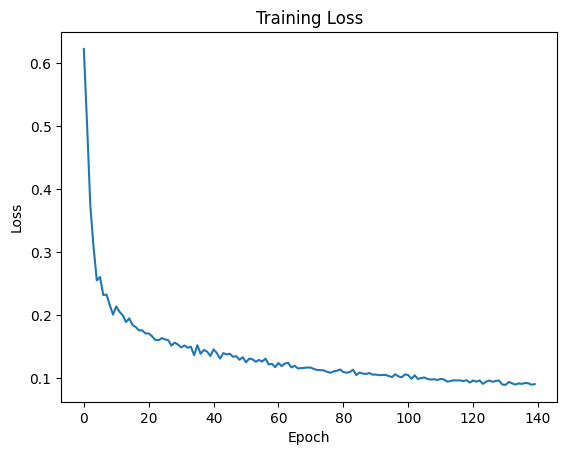

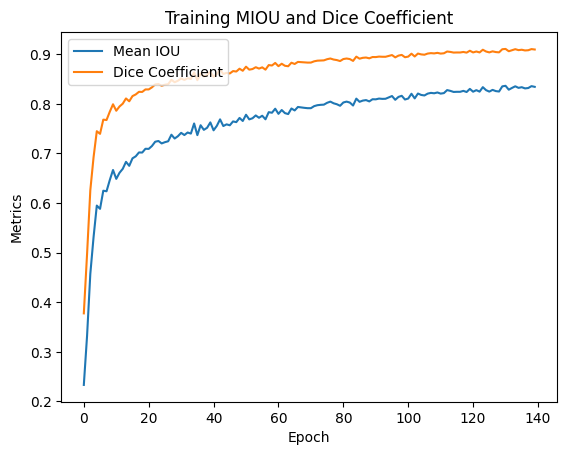

In [31]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Plot the training MIOU and dice_coef on the same plot
plt.plot(history.history["mean_iou"], label='Mean IOU')
plt.plot(history.history["dice_coef"], label='Dice Coefficient')
plt.title("Training MIOU and Dice Coefficient")
plt.ylabel("Metrics")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()


In [25]:
def mean_iouTEST(y_true, y_pred, num_classes=4):
  smooth = 1e-7  
  y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[..., 1:])
  y_pred_f = K.flatten(K.one_hot(K.cast(y_pred, 'int32'), num_classes=num_classes)[..., 1:])
  # y_pred_f = K.flatten(y_pred[..., 1:])
  intersection = K.sum(K.cast(y_true_f * y_pred_f, dtype='float32'), axis=-1)
  set_sum = K.sum(K.cast(y_true_f + y_pred_f, dtype='float32'), axis=-1)
  iou = (intersection + smooth) / (set_sum -intersection+ smooth)
  mIoU = K.mean(iou)
  return mIoU.numpy()

def dice_coefTEST(y_true, y_pred, smooth=1e-7):
    smooth = 1e-7  
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[..., 1:])
    y_pred_f = K.flatten(K.one_hot(K.cast(y_pred, 'int32'), num_classes=num_classes)[..., 1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    true_sum = K.sum(y_true_f , axis=-1)
    pred_sum = K.sum(y_pred_f, axis=-1)
    return K.mean((2. * intersect / (true_sum+pred_sum + smooth)))

In [26]:
def display_sample(sample_image,sample_mask_seperated,pred_mask_seperated):
    title = ['reticulin','fat','cell','bone']
    fig,axs=plt.subplots(2,5,figsize=(30,12))
    axs[0][0].imshow(sample_image)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original Image')
    for i in range(4):
        axs[0][i+1].imshow(sample_mask_seperated[i],cmap='gray')
        axs[0][i+1].axis('off')
        axs[0][i+1].set_title(f'Original {title[i]}')
    for i in range(4):
        axs[1][i+1].imshow(pred_mask_seperated[i],cmap='gray')
        axs[1][i+1].axis('off')
        axs[1][i+1].set_title(f'Predicted {title[i]}')
    plt.show()



    

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(sample_image,sample_mask):
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    print(prediction.shape)
    pred_mask = create_mask(prediction)

    miou=mean_iouTEST(sample_mask[0],pred_mask)
    dice=dice_coefTEST(sample_mask[0],pred_mask)
    sample_mask_seperated=[(sample_mask[0]==i) for i in [0,1,2,3]]
    pred_mask_seperated=[(pred_mask[0]==i) for i in [0,1,2,3]]

    display_sample(sample_image[0], sample_mask_seperated,pred_mask_seperated)
    print(f"mIoU={miou*100:.3f}%\t")

    return miou*100,dice*100

2024-06-25 23:43:13.000679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/batch_normalization_29/FusedBatchNormV3' exist for missing node 'model/conv2d_19/BiasAdd'.


1/1 [==============================] - 1s 859ms/step
(1, 512, 512, 4)


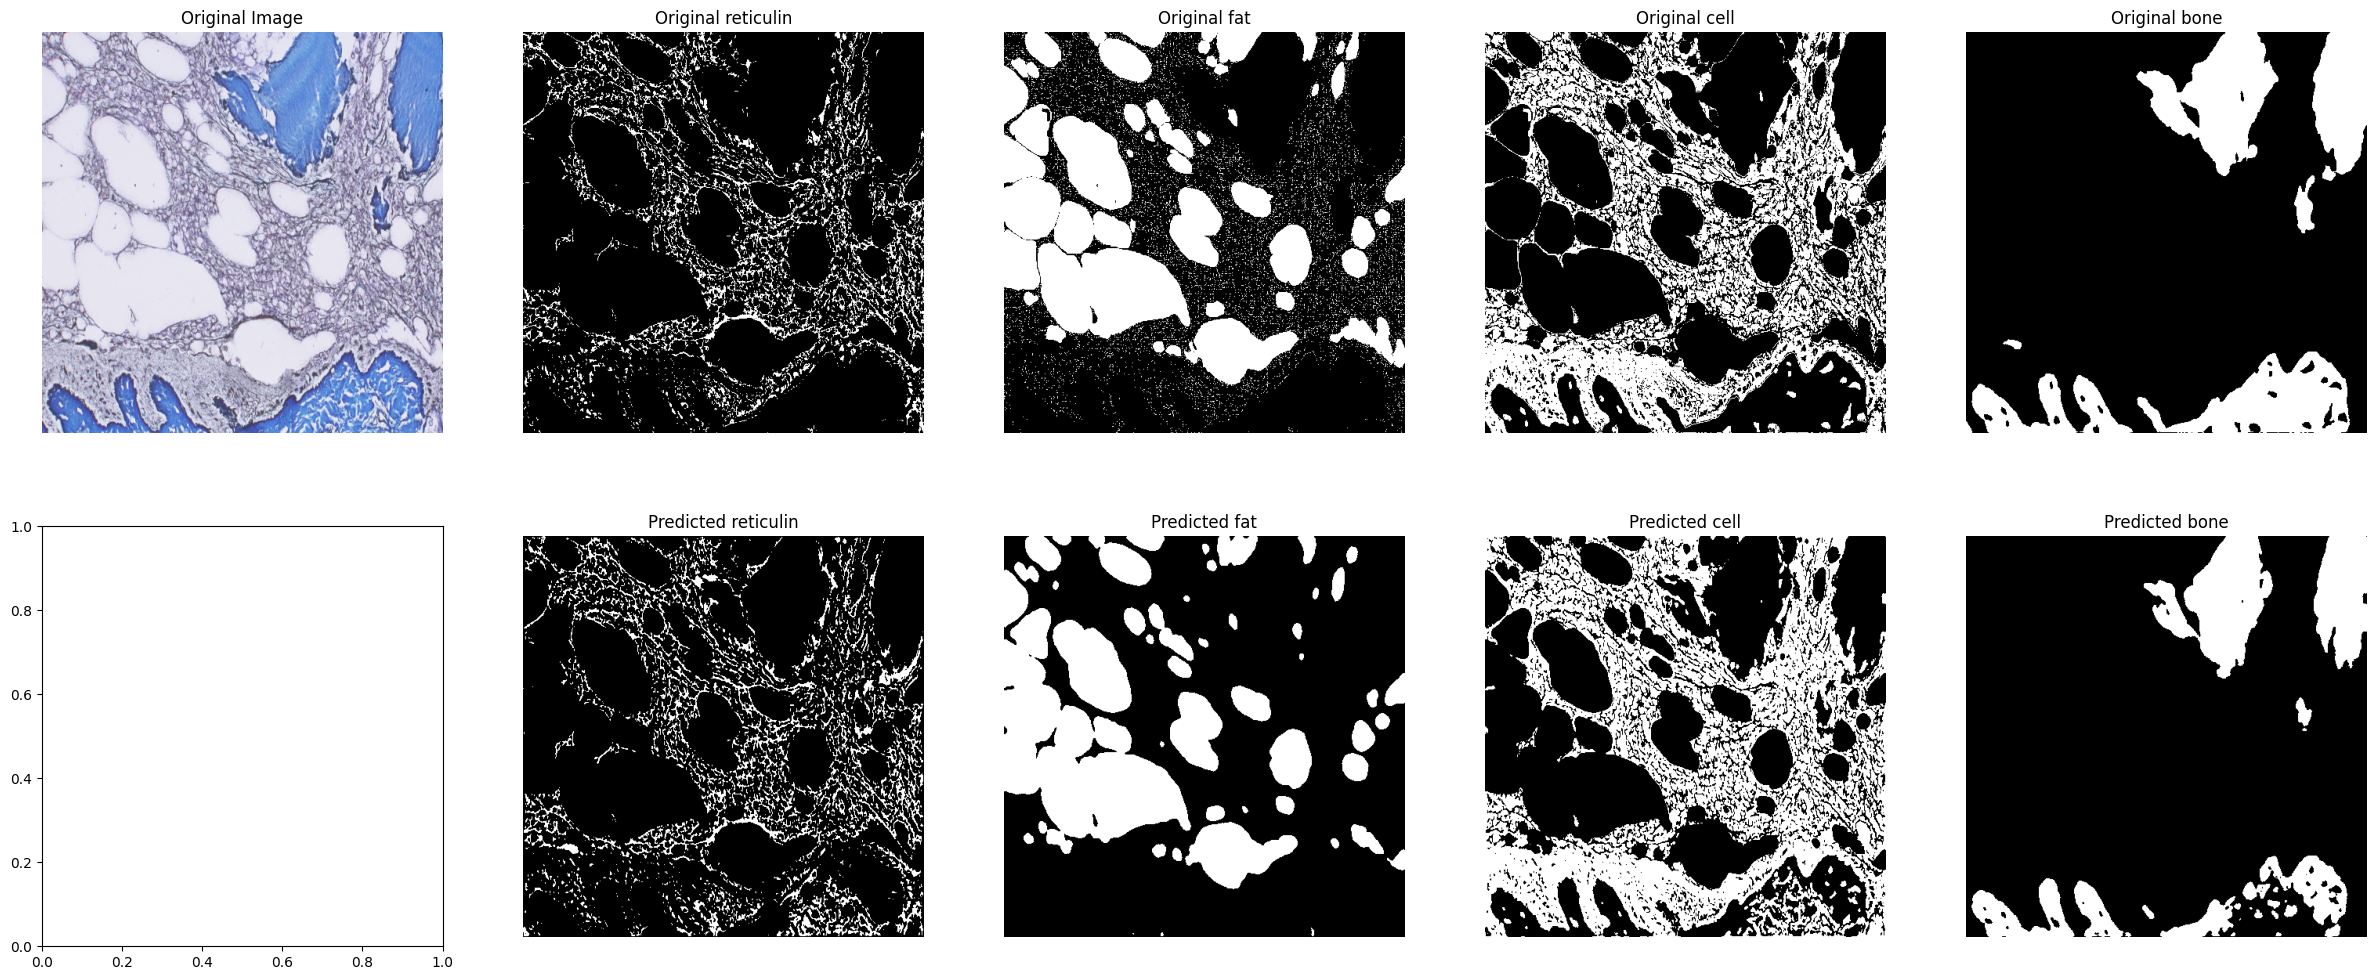

mIoU=77.305%	
1/1 [==============================] - 0s 194ms/step
(1, 512, 512, 4)


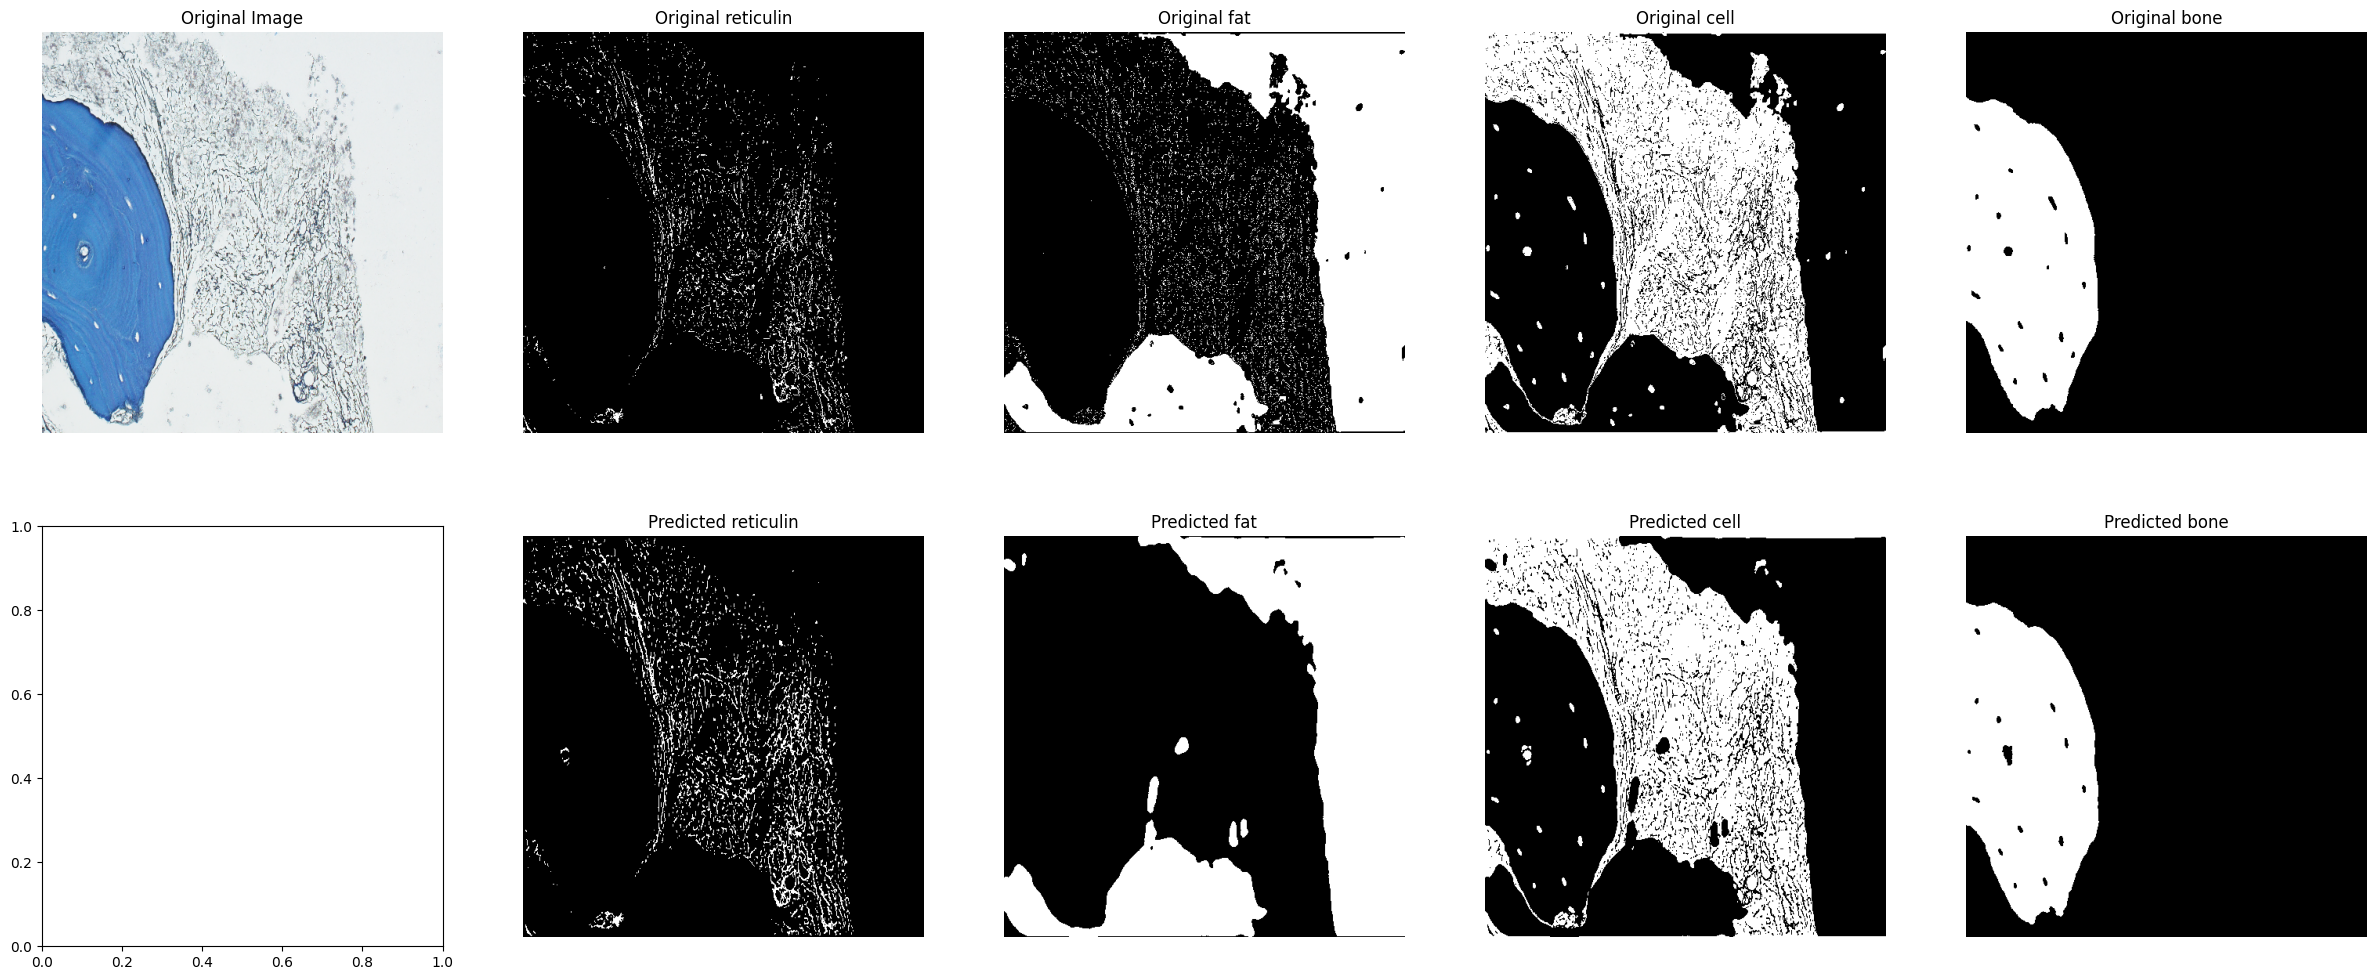

mIoU=89.017%	


In [28]:
def tf_dataset_test(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset=dataset.repeat()
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
test_dataset = tf_dataset_test(test_x, test_y)

net_miou=[]
net_dice=[]
totalMasks=15

for image, mask in test_dataset.take(2):
        sample_image, sample_mask = image, mask
        miou,dice=show_predictions(sample_image, sample_mask)
        net_miou.append(miou)
        net_dice.append(dice)

In [29]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0: 
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
print(f"Testing mean_iou Standard Deviation: {np.std(net_miou):.3f}")
print(f"Testing dice Standard Deviation: {np.std(net_dice):.3f}")

5/5 [==============================] - 9s 2s/step - loss: 0.1123 - dice_coef: 0.8877 - mean_iou: 0.7982
Testing mean_iou Standard Deviation: 5.856
Testing dice Standard Deviation: 3.495


In [ ]:
model.save('Xception_512_45.keras')